In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
ratings = pd.read_csv('ml-100k/u.data', sep='\t', 
                     names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', 
                    usecols=[0,1], names=['item_id', 'title'])

# Create mappings
user_ids = ratings['user_id'].unique()
user2idx = {o:i for i, o in enumerate(user_ids)}
item_ids = ratings['item_id'].unique()
item2idx = {o:i for i, o in enumerate(item_ids)}

# Add mapped indices
ratings['user_idx'] = ratings['user_id'].map(user2idx)
ratings['item_idx'] = ratings['item_id'].map(item2idx)

# Split data
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

In [2]:
class MovieLensDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = torch.LongTensor(users)
        self.items = torch.LongTensor(items)
        self.ratings = torch.FloatTensor(ratings)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_dataset = MovieLensDataset(
    train_df['user_idx'].values,
    train_df['item_idx'].values,
    train_df['rating'].values)
test_dataset = MovieLensDataset(
    test_df['user_idx'].values,
    test_df['item_idx'].values,
    test_df['rating'].values)

In [3]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=50):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        
        # Initialize parameters
        self.user_emb.weight.data.uniform_(-0.01, 0.01)
        self.item_emb.weight.data.uniform_(-0.01, 0.01)
        self.user_bias.weight.data.zero_()
        self.item_bias.weight.data.zero_()
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U * V).sum(1) + b_u + b_v

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MatrixFactorization(len(user_ids), len(item_ids)).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
train_losses = []
test_losses = []
epochs = 40

for epoch in range(epochs):
    # Training
    model.train()
    epoch_loss = 0
    for u, v, r in train_loader:
        u, v, r = u.to(device), v.to(device), r.to(device)
        
        optimizer.zero_grad()
        pred = model(u, v)
        loss = loss_fn(pred, r)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss/len(train_loader))
    
    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for u, v, r in test_loader:
            u, v, r = u.to(device), v.to(device), r.to(device)
            pred = model(u, v)
            test_loss += loss_fn(pred, r).item()
    test_losses.append(test_loss/len(test_loader))
    
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}')

Epoch 01 | Train Loss: 13.2100 | Test Loss: 12.1963
Epoch 02 | Train Loss: 9.7249 | Test Loss: 6.6388
Epoch 03 | Train Loss: 4.1772 | Test Loss: 2.3551
Epoch 04 | Train Loss: 1.6929 | Test Loss: 1.3361
Epoch 05 | Train Loss: 1.1760 | Test Loss: 1.1066
Epoch 06 | Train Loss: 1.0240 | Test Loss: 1.0150
Epoch 07 | Train Loss: 0.9534 | Test Loss: 0.9698
Epoch 08 | Train Loss: 0.9164 | Test Loss: 0.9444
Epoch 09 | Train Loss: 0.8944 | Test Loss: 0.9295
Epoch 10 | Train Loss: 0.8822 | Test Loss: 0.9203
Epoch 11 | Train Loss: 0.8698 | Test Loss: 0.9139
Epoch 12 | Train Loss: 0.8649 | Test Loss: 0.9101
Epoch 13 | Train Loss: 0.8612 | Test Loss: 0.9074
Epoch 14 | Train Loss: 0.8589 | Test Loss: 0.9056
Epoch 15 | Train Loss: 0.8552 | Test Loss: 0.9049
Epoch 16 | Train Loss: 0.8527 | Test Loss: 0.9030
Epoch 17 | Train Loss: 0.8519 | Test Loss: 0.9023
Epoch 18 | Train Loss: 0.8492 | Test Loss: 0.9008
Epoch 19 | Train Loss: 0.8486 | Test Loss: 0.8998
Epoch 20 | Train Loss: 0.8486 | Test Loss: 0.899

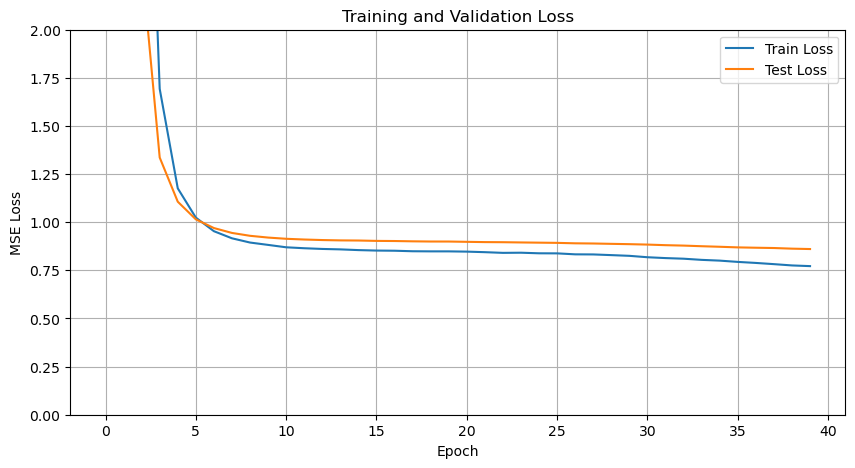

/tmp/ipykernel_160106/2846112050.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pred_dict[ii] for ii in unique_actuals], labels=unique_actuals)


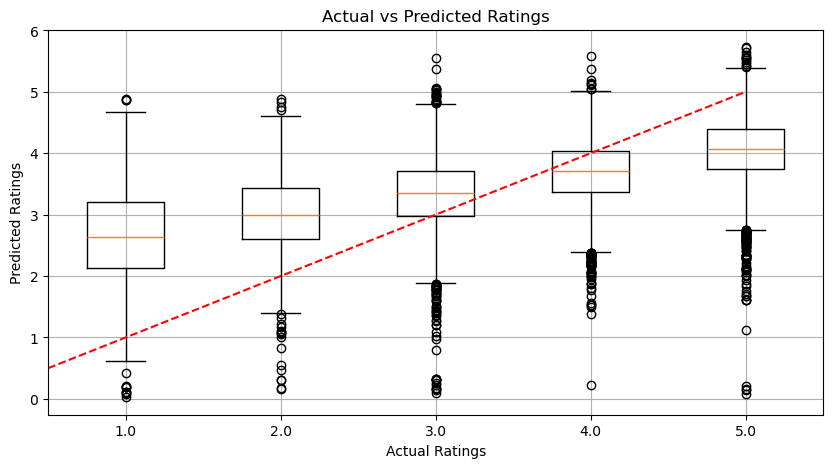

In [6]:
# Loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.ylim([0, 2])
plt.legend()
plt.grid()
plt.show()

# Actual vs Predicted ratings
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for u, v, r in test_loader:
        u, v, r = u.to(device), v.to(device), r.to(device)
        pred = model(u, v)
        preds.extend(pred.cpu().numpy())
        actuals.extend(r.cpu().numpy())
preds = np.array(preds)
actuals = np.array(actuals)
unique_actuals = np.unique(actuals)
pred_dict = {ii: preds[actuals == ii] for ii in unique_actuals}

plt.figure(figsize=(10,5))

plt.boxplot([pred_dict[ii] for ii in unique_actuals], labels=unique_actuals)
plt.plot([0.5,5], [0.5,5], 'r--')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid()
plt.show()

In [7]:
def recommend(user_id, n=10):
    user_idx = user2idx[user_id]
    all_items = torch.LongTensor(list(item2idx.values())).to(device)
    user_vector = torch.LongTensor([user_idx]*len(all_items)).to(device)
    
    with torch.no_grad():
        ratings = model(user_vector, all_items)
    top_items = all_items.cpu().numpy()[np.argsort(-ratings.cpu().numpy())[:n]]
    
    return movies[movies['item_id'].isin([item_ids[i] for i in top_items])]

# Example recommendation for user 1
print("Recommendations for user 1:")
recommend(1).head(10)

Recommendations for user 1:


,item_id,title
126,127,"Godfather, The (1972)"
319,320,Paradise Lost: The Child Murders at Robin Hood...
407,408,"Close Shave, A (1995)"
482,483,Casablanca (1942)
866,867,"Whole Wide World, The (1996)"
1366,1367,Faust (1994)
1367,1368,Mina Tannenbaum (1994)
1448,1449,Pather Panchali (1955)
1499,1500,Santa with Muscles (1996)
1638,1639,Bitter Sugar (Azucar Amargo) (1996)
